In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from xgboost import XGBRegressor 
from sklearn.model_selection import KFold 
from sklearn.metrics import accuracy_score 
from category_encoders import OrdinalEncoder
from sklearn.metrics import r2_score

import statsmodels.api as sm
from scipy import stats
import statsmodels.formula.api as ols

from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV

import shap
from pdpbox.pdp import pdp_interact, pdp_interact_plot
from pdpbox.pdp import pdp_isolate, pdp_plot


import warnings
warnings.filterwarnings('ignore')

In [ ]:
pip install shap
pip install pdpbox

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/codestates/Section2/project/bus_station/train.csv',encoding = 'utf-8')
test = pd.read_csv('/content/drive/MyDrive/codestates/Section2/project/bus_station/test.csv',encoding = 'utf-8')
result = pd.read_csv('/content/drive/MyDrive/codestates/Section2/project/bus_station/submission.csv',encoding = 'utf-8')

In [ ]:
train.head()

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time
0,0,2019-10-15,405136001,7997025,360-1,33.456267,126.551750,제주대학교입구,06시,266.0,제대마을,33.457724,126.554014,24
1,1,2019-10-15,405136001,7997025,360-1,33.457724,126.554014,제대마을,06시,333.0,제대아파트,33.458783,126.557353,36
2,2,2019-10-15,405136001,7997025,360-1,33.458783,126.557353,제대아파트,06시,415.0,제주대학교,33.459893,126.561624,40
3,3,2019-10-15,405136001,7997025,360-1,33.479705,126.543811,남국원(아라방면),06시,578.0,제주여자중고등학교(아라방면),33.484860,126.542928,42
4,4,2019-10-15,405136001,7997025,360-1,33.485662,126.494923,도호동,07시,374.0,은남동,33.485822,126.490897,64


In [ ]:
train.columns

Index(['id', 'date', 'route_id', 'vh_id', 'route_nm', 'now_latitude',
       'now_longitude', 'now_station', 'now_arrive_time', 'distance',
       'next_station', 'next_latitude', 'next_longitude', 'next_arrive_time'],
      dtype='object')

In [ ]:
print("train set 크기 : ",train.shape)
print("test set 크기 : ",test.shape)

train set 크기 :  (210457, 14)
test set 크기 :  (91774, 13)


In [ ]:
train.isnull().sum()

id                  0
date                0
route_id            0
vh_id               0
route_nm            0
now_latitude        0
now_longitude       0
now_station         0
now_arrive_time     0
distance            0
next_station        0
next_latitude       0
next_longitude      0
next_arrive_time    0
dtype: int64

In [ ]:
test.isnull().sum()

id                 0
date               0
route_id           0
vh_id              0
route_nm           0
now_latitude       0
now_longitude      0
now_station        0
now_arrive_time    0
distance           0
next_station       0
next_latitude      0
next_longitude     0
dtype: int64

In [ ]:
#Proportion btw test and train
print("proportion:", round(len(test) / len(train),2))

proportion: 0.44


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210457 entries, 0 to 210456
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                210457 non-null  int64  
 1   date              210457 non-null  object 
 2   route_id          210457 non-null  int64  
 3   vh_id             210457 non-null  int64  
 4   route_nm          210457 non-null  object 
 5   now_latitude      210457 non-null  float64
 6   now_longitude     210457 non-null  float64
 7   now_station       210457 non-null  object 
 8   now_arrive_time   210457 non-null  object 
 9   distance          210457 non-null  float64
 10  next_station      210457 non-null  object 
 11  next_latitude     210457 non-null  float64
 12  next_longitude    210457 non-null  float64
 13  next_arrive_time  210457 non-null  int64  
dtypes: float64(5), int64(4), object(5)
memory usage: 22.5+ MB


In [ ]:
train.describe()

,id,route_id,vh_id,now_latitude,now_longitude,distance,next_latitude,next_longitude,next_arrive_time
count,210457.000000,2.104570e+05,2.104570e+05,210457.000000,210457.000000,210457.000000,210457.000000,210457.000000,210457.000000
mean,105228.000000,4.052491e+08,7.988694e+06,33.434528,126.603451,490.256100,33.434711,126.603687,85.380824
std,60753.847139,9.132404e+04,6.774077e+03,0.102350,0.123961,520.563932,0.102224,0.123838,85.051170
min,0.000000,4.051360e+08,7.983000e+06,33.244382,126.473300,97.000000,33.244382,126.473300,6.000000
25%,52614.000000,4.051365e+08,7.983093e+06,33.325283,126.523900,291.000000,33.325283,126.524550,44.000000
50%,105228.000000,4.053201e+08,7.983431e+06,33.484667,126.551050,384.000000,33.484860,126.551050,66.000000
75%,157842.000000,4.053201e+08,7.997041e+06,33.500197,126.650322,542.000000,33.500228,126.650322,102.000000
max,210456.000000,4.053281e+08,7.997124e+06,33.556167,126.935188,7461.000000,33.556167,126.935188,2996.000000


In [ ]:
train.duplicated().sum()

0

In [ ]:
#가장 빈번하게 나타나는 route_id 확인 : 405136522
train['route_id'].mode()

0    405136522
dtype: int64

In [ ]:
#버스노선 : 21종류
len(train['route_id'].value_counts())

21

In [ ]:
#버스노선 종류
train['route_id'].value_counts()

405136522    31941
405328102    25884
405136001    21668
405328101    19150
405320116    15451
405320114    12999
405320112    11871
405136521    11826
405136012     8037
405320111     7895
405320122     7723
405136002     7709
405320127     5950
405320117     5102
405320121     2670
405320126     2665
405320113     2631
405320118     2558
405320124     2368
405320115     2289
405136007     2070
Name: route_id, dtype: int64

In [ ]:
train.columns

Index(['id', 'date', 'route_id', 'vh_id', 'route_nm', 'now_latitude',
       'now_longitude', 'now_station', 'now_arrive_time', 'distance',
       'next_station', 'next_latitude', 'next_longitude', 'next_arrive_time'],
      dtype='object')

In [ ]:
#소요시간 구간별 평균소요시간 내림차순으로 정리

average_time = train[['route_id','next_arrive_time']].groupby('route_id').mean()

average_time.sort_values('next_arrive_time', ascending = False)

,next_arrive_time
route_id,
405136521,114.673939
405136012,111.322633
405136002,108.270852
405136522,101.339188
405136007,94.172947
405136001,92.063688
405328101,87.579634
405328102,85.744862
405320115,71.313237


In [ ]:
import lightgbm as lgb
import folium

In [ ]:
#가설 : 도심부일수록 교통체증의 증가로 예상 평균소요시간이 길 것이며, 외각지역일수록 교통체증의 덜 함으로 예상 평균소요시간이 짧을 것이다.
#시간이 가장 긴 노선


In [ ]:
#노션별 제주도 마커 표시 , 평균 arrival time 63sec, route_id = 405320122

map_data = train[['route_id','now_latitude','now_longitude','now_station']]

map_bus_route = map_data[map_data['route_id'] == 405320122].drop_duplicates('now_station')

map_osm = folium.Map(location = [33.4134, 126.5190],zoom_start = 10.5)

for item in map_bus_route.index :
  lat = map_bus_route.loc[item,'now_latitude']
  long = map_bus_route.loc[item,'now_longitude']

  folium.Marker([lat,long],popup = map_bus_route.loc[item, 'now_station'],
                icon = folium.Icon(color = 'red', icon = 'info-sign')
                ).add_to(map_osm)

map_osm.save('index_html')
map_osm

In [ ]:
#노선 별 정류장 명칭 확인

route_405320122 = train[train.route_id == 405320122]

route_405320122['now_station'].value_counts()

김녕환승정류장(김녕초등학교)    110
함덕환승정류장(함덕해수욕장)    106
함덕리 3구             106
세화리시장2동            104
서귀포시 구 버스터미널       102
                  ... 
신흥1번지                6
화성농장                 5
토산관광지구입구             4
수농원                  3
신천리취락구조              3
Name: now_station, Length: 187, dtype: int64

In [ ]:
route_405320121	= train[train.route_id == 405320121]

route_405320121['now_station'].value_counts()

종달초등학교             39
함덕농협지소             35
함덕환승정류장(함덕해수욕장)    35
성산포수협표선지점          35
시흥리                35
                   ..
온평리                 1
LH아파트               1
원당분화원               1
신풍리하동               1
광대왓                 1
Name: now_station, Length: 180, dtype: int64

In [ ]:
route_405328102 = train[train.route_id == 405328102]

route_405328102['now_station'].value_counts()

동문로터리              992
고산동산(광양방면)         849
제주여자중고등학교(광양방면)    837
매일올레시장 7번입구        808
서귀포시 구 버스터미널       795
                  ... 
입석동                 96
남국사                 73
마방목지                65
한라산 둘레길             60
견월교                 49
Name: now_station, Length: 64, dtype: int64

In [ ]:
#노션별 제주도 마커 표시 , 평균 arrival time 70sec, route_id = 405320127

map_data = train[['route_id','now_latitude','now_longitude','now_station']]

map_bus_route_405328102 = map_data[map_data['route_id'] == 405320127].drop_duplicates('now_station')

map_osm = folium.Map(location = [33.4134, 126.5190],zoom_start = 10.5)

for item in map_bus_route_405328102.index :
  lat = map_bus_route_405328102.loc[item,'now_latitude']
  long = map_bus_route_405328102.loc[item,'now_longitude']

  folium.Marker([lat,long],popup = map_bus_route_405328102.loc[item, 'now_station'],
                icon = folium.Icon(color = 'red', icon = 'info-sign')
                ).add_to(map_osm)

map_osm.save('index_html')
map_osm

In [ ]:
#노션별 제주도 마커 표시 , 평균 arrival time 114sec, route_id = 405136521

map_data = train[['route_id','now_latitude','now_longitude','now_station']]

map_bus_route_405328102 = map_data[map_data['route_id'] == 405136521].drop_duplicates('now_station')

map_osm = folium.Map(location = [33.4134, 126.5190],zoom_start = 10.5)

for item in map_bus_route_405328102.index :
  lat = map_bus_route_405328102.loc[item,'now_latitude']
  long = map_bus_route_405328102.loc[item,'now_longitude']

  folium.Marker([lat,long],popup = map_bus_route_405328102.loc[item, 'now_station'],
                icon = folium.Icon(color = 'red', icon = 'info-sign')
                ).add_to(map_osm)

map_osm.save('index_html')
map_osm

In [ ]:
#노션별 제주도 마커 표시 , 평균 arrival time 87sec, route_id = 405328101

map_data = train[['route_id','now_latitude','now_longitude','now_station']]

map_bus_route_405328102 = map_data[map_data['route_id'] == 405328101].drop_duplicates('now_station')

map_osm = folium.Map(location = [33.4134, 126.5190],zoom_start = 10.5)

for item in map_bus_route_405328102.index :
  lat = map_bus_route_405328102.loc[item,'now_latitude']
  long = map_bus_route_405328102.loc[item,'now_longitude']

  folium.Marker([lat,long],popup = map_bus_route_405328102.loc[item, 'now_station'],
                icon = folium.Icon(color = 'red', icon = 'info-sign')
                ).add_to(map_osm)

map_osm.save('index_html')
map_osm

In [ ]:
#Target data 확인
train['next_arrive_time'].value_counts()

44      5704
42      5693
46      5624
40      5464
50      5342
        ... 
2046       1
1624       1
1016       1
1442       1
1392       1
Name: next_arrive_time, Length: 596, dtype: int64

In [ ]:
print("가장 오래 걸린 시간 : ",train['next_arrive_time'].max())
print("가장 짧게 걸린 시간: ", train['next_arrive_time'].min())

가장 오래 걸린 시간 :  2996
가장 짧게 걸린 시간:  6


In [ ]:
print("가장 먼 거리 : ",train['distance'].max())
print("가장 가까운 거리: ", train['distance'].min())

가장 먼 거리 :  7461.0
가장 가까운 거리:  97.0


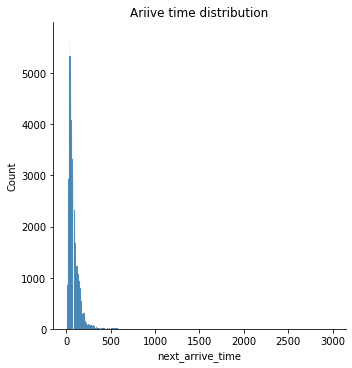

In [ ]:
sns.displot(train['next_arrive_time'])

plt.title('Ariive time distribution')
plt.show()

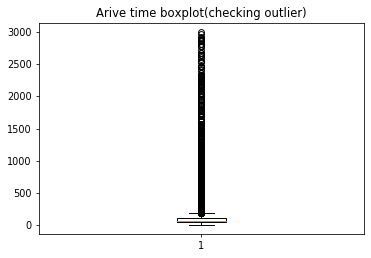

In [ ]:
fig, ax = plt.subplots()

ax.boxplot([train['next_arrive_time']])

plt.title('Arive time boxplot(checking outlier)')
plt.show()

In [ ]:
train.sort_values('next_arrive_time',ascending = False).head(3)

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time
35950,35950,2019-10-17,405136522,7997056,365-22,33.459893,126.561624,제주대학교,18시,415.0,제대아파트,33.458783,126.557353,2996
34404,34404,2019-10-17,405136012,7997041,360-12,33.460114,126.561659,제주대학교,19시,435.0,제대아파트,33.458900,126.557300,2966
110733,110733,2019-10-22,405136521,7997031,365-21,33.458900,126.557300,제대아파트,07시,435.0,제주대학교,33.460114,126.561659,2930


In [ ]:
#Outlier 찾는 barplot? 그리기

In [ ]:
print("가장 먼 거리 : ",train['distance'].max())
print("가장 짧은 거리 : ", train['distance'].min())

가장 먼 거리 :  7461.0
가장 짧은 거리 :  97.0


In [ ]:
train_dis_check = train.loc[(train['distance']== 7461.0)]

train_dis_check.sort_values('next_arrive_time',ascending = False).head(3)

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time
29340,29340,2019-10-16,405328101,7983482,281-1,33.384634,126.620353,성판악,17시,7461.0,수악교,33.334694,126.61037,664
60518,60518,2019-10-18,405328101,7983483,281-1,33.384634,126.620353,성판악,18시,7461.0,수악교,33.334694,126.61037,658
28530,28530,2019-10-16,405328101,7983417,281-1,33.384634,126.620353,성판악,06시,7461.0,수악교,33.334694,126.61037,656


In [ ]:
#가장 먼 거리의 가장 오래 걸린시간이 664s
#이에 670s 이상 운행하는 구간은 측정 오류로 판단하여 삭제
#325개

train[(train.next_arrive_time >670 )]

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time
1785,1785,2019-10-15,405136002,7997043,360-2,33.458900,126.557300,제대아파트,07시,435.0,제주대학교,33.460114,126.561659,2082
1840,1840,2019-10-15,405136002,7997082,360-2,33.458900,126.557300,제대아파트,05시,435.0,제주대학교,33.460114,126.561659,1372
2003,2003,2019-10-15,405136002,7997082,360-2,33.458900,126.557300,제대아파트,17시,435.0,제주대학교,33.460114,126.561659,2906
2113,2113,2019-10-15,405136002,7997111,360-2,33.477560,126.477406,탐라도서관,12시,518.0,제주고등학교/중흥S클래스,33.476260,126.481417,862
2191,2191,2019-10-15,405136002,7997111,360-2,33.477560,126.477406,탐라도서관,18시,518.0,제주고등학교/중흥S클래스,33.476260,126.481417,688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199675,199675,2019-10-28,405136521,7997089,365-21,33.476401,126.479759,시티주유소,19시,431.0,제주한라대학교(종점),33.477787,126.475740,1428
199818,199818,2019-10-28,405136522,7997002,365-22,33.502112,126.527961,광양,16시,253.0,삼성초등학교,33.504099,126.526639,2112
200069,200069,2019-10-28,405136522,7997032,365-22,33.476533,126.544283,아라초등학교,06시,355.0,남국원(아라방면),33.479705,126.543811,980
201187,201187,2019-10-28,405136522,7997107,365-22,33.458783,126.557353,제대아파트,18시,415.0,제주대학교,33.459893,126.561624,2874


In [ ]:
train = train[train['next_arrive_time']<670]

#원래 data set , 210457
train.shape

(210128, 14)

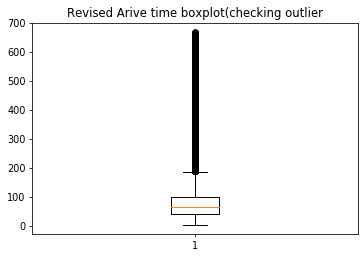

In [ ]:
#revised boxplot

fig, ax = plt.subplots()

ax.boxplot([train['next_arrive_time']])

plt.title('Revised Arive time boxplot(checking outlier')
plt.show()

가설검정

In [ ]:
train.columns

Index(['id', 'date', 'route_id', 'vh_id', 'route_nm', 'now_latitude',
       'now_longitude', 'now_station', 'now_arrive_time', 'distance',
       'next_station', 'next_latitude', 'next_longitude', 'next_arrive_time'],
      dtype='object')

In [ ]:
#distance 670이상으로 했을 때 kurtosis : 16.055(기준 3), skew : 2.596(기준 0)
#target에 log값 적용시  kurtosis : 2.915(기준 3), skew : 0.243(기준 0)


feature = ['now_latitude','now_longitude','now_arrive_time','distance'] # 더 변수는 개별적으로 시도해보자!! 오케잉
#target = ['next_arrive_time']

#x2 = sm.add_constant(train[feature])
est =sm.OLS.from_formula("next_arrive_time ~ distance",data=train)
est2 = est.fit()
print(est2.summary())


                            OLS Regression Results                            
Dep. Variable:       next_arrive_time   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                 1.122e+05
Date:                Mon, 21 Mar 2022   Prob (F-statistic):               0.00
Time:                        22:13:37   Log-Likelihood:            -1.1243e+06
No. Observations:              210128   AIC:                         2.249e+06
Df Residuals:                  210126   BIC:                         2.249e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     48.2881      0.153    316.056      0.0

평가지표

In [ ]:
predict = train['next_arrive_time'].mean()

print('기준모델 값:',round(predict,0))

기준모델 값: 83.0


In [ ]:
errors = predict -train['next_arrive_time']

errors.head()

0    59.362094
1    47.362094
2    43.362094
3    41.362094
4    19.362094
Name: next_arrive_time, dtype: float64

In [ ]:
x = train['distance']
y = train['next_arrive_time']

y_pred = 0.125* x + train['next_arrive_time'].mean()
r2 = -1*r2_score(y, y_pred)

r2 # 회귀모델이 얼마나 설명력이 있는지 확인, 1에 가까울수록 설명력이 있음


0.7876444417039896

In [ ]:
print("train set 빠른 일자 : ",train['date'].min())
print("train set 늦은 일자 : ", train['date'].max())

print("test set 빠른 일자 : ",test['date'].min())
print("test set 늦은 일자 : ", test['date'].max())

train set 빠른 일자 :  2019-10-15
train set 늦은 일자 :  2019-10-28
test set 빠른 일자 :  2019-10-29
test set 늦은 일자 :  2019-11-05


In [ ]:
train['now_arrive_time']

0         06시
1         06시
2         06시
3         06시
4         07시
         ... 
210452    21시
210453    21시
210454    21시
210455    21시
210456    21시
Name: now_arrive_time, Length: 210128, dtype: object

In [ ]:
## train data

train['date'] = pd.to_datetime(train['date']) # date 값을 datetime으로
train['weekday'] = train['date'].dt.weekday  # Monday 0, Sunday 6
train['weekday'] = train['weekday'].apply(lambda x: 0 if x < 5 else 1) 
# 0 ~ 5 는 월요일 ~ 금요일이므로 평일이면 0, 주말이면 1을 설정하였다

train = pd.get_dummies(train, columns=['weekday']) # 평일/주말에 대해 One-hot Encoding

train = train.drop('date', axis=1) # 필요없는 date 칼럼을 drop
train.head()

,id,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time,weekday_0,weekday_1
0,0,405136001,7997025,360-1,33.456267,126.551750,제주대학교입구,06시,266.0,제대마을,33.457724,126.554014,24,1,0
1,1,405136001,7997025,360-1,33.457724,126.554014,제대마을,06시,333.0,제대아파트,33.458783,126.557353,36,1,0
2,2,405136001,7997025,360-1,33.458783,126.557353,제대아파트,06시,415.0,제주대학교,33.459893,126.561624,40,1,0
3,3,405136001,7997025,360-1,33.479705,126.543811,남국원(아라방면),06시,578.0,제주여자중고등학교(아라방면),33.484860,126.542928,42,1,0
4,4,405136001,7997025,360-1,33.485662,126.494923,도호동,07시,374.0,은남동,33.485822,126.490897,64,1,0


In [ ]:
## test data
# 시험데이터도 마찬가지로 처리해준다.

test['date'] = pd.to_datetime(test['date'])
test['weekday'] = test['date'].dt.weekday  # Monday 0, Sunday 6
test['weekday'] = test['weekday'].apply(lambda x: 0 if x < 5 else 1)
test = pd.get_dummies(test, columns=['weekday'])

test = test.drop('date', axis=1)
test.head()

,id,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,weekday_0,weekday_1
0,210457,405136001,7997025,360-1,33.457724,126.554014,제대마을,07시,333.0,제대아파트,33.458783,126.557353,1,0
1,210458,405136001,7997025,360-1,33.458783,126.557353,제대아파트,07시,415.0,제주대학교,33.459893,126.561624,1,0
2,210459,405136001,7997025,360-1,33.478867,126.483833,한라중학교/부영아파트,08시,417.0,대림2차아파트,33.478850,126.488350,1,0
3,210460,405136001,7997025,360-1,33.478850,126.488350,대림2차아파트,08시,334.0,연동대림1차아파트,33.480700,126.489933,1,0
4,210461,405136001,7997025,360-1,33.480700,126.489933,연동대림1차아파트,08시,550.0,케이티앤지,33.482077,126.485355,1,0


In [ ]:
## train data

train['time_group']='group' #time_group 변수를 미리 생성

train.loc[ (train['now_arrive_time']>='05시') & (train['now_arrive_time']<'12시') ,['time_group'] ]= 'morning' # 05~11시
train.loc[ (train['now_arrive_time']>='12시') & (train['now_arrive_time']<'18시') ,['time_group'] ]= 'afternoon' #12~17시
train.loc[ (train['now_arrive_time']>='18시') | (train['now_arrive_time']=='00시'),['time_group'] ]= 'evening' #18~00시

train = pd.get_dummies(train,columns=['time_group']) # 원 핫 인코딩을 수행
train = train.drop('now_arrive_time', axis=1) # 필요없는 now_arrive_time drop
train.head()

,id,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,distance,next_station,next_latitude,next_longitude,next_arrive_time,weekday_0,weekday_1,time_group_afternoon,time_group_evening,time_group_morning
0,0,405136001,7997025,360-1,33.456267,126.551750,제주대학교입구,266.0,제대마을,33.457724,126.554014,24,1,0,0,0,1
1,1,405136001,7997025,360-1,33.457724,126.554014,제대마을,333.0,제대아파트,33.458783,126.557353,36,1,0,0,0,1
2,2,405136001,7997025,360-1,33.458783,126.557353,제대아파트,415.0,제주대학교,33.459893,126.561624,40,1,0,0,0,1
3,3,405136001,7997025,360-1,33.479705,126.543811,남국원(아라방면),578.0,제주여자중고등학교(아라방면),33.484860,126.542928,42,1,0,0,0,1
4,4,405136001,7997025,360-1,33.485662,126.494923,도호동,374.0,은남동,33.485822,126.490897,64,1,0,0,0,1


In [ ]:
## test data

test['time_group']='group' #time_group 변수를 미리 생성

test.loc[ (test['now_arrive_time']>='05시') & (test['now_arrive_time']<'12시') ,['time_group'] ]= 'morning' # 05~11시
test.loc[ (test['now_arrive_time']>='12시') & (test['now_arrive_time']<'18시') ,['time_group'] ]= 'afternoon' #12~17시
test.loc[ (test['now_arrive_time']>='18시') | (test['now_arrive_time']=='00시'),['time_group'] ]= 'evening' #18~00시

test = pd.get_dummies(test,columns=['time_group']) # 원 핫 인코딩을 수행
test = test.drop('now_arrive_time', axis=1) # 필요없는 now_arrive_time drop
test.head()

,id,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,distance,next_station,next_latitude,next_longitude,weekday_0,weekday_1,time_group_afternoon,time_group_evening,time_group_morning
0,210457,405136001,7997025,360-1,33.457724,126.554014,제대마을,333.0,제대아파트,33.458783,126.557353,1,0,0,0,1
1,210458,405136001,7997025,360-1,33.458783,126.557353,제대아파트,415.0,제주대학교,33.459893,126.561624,1,0,0,0,1
2,210459,405136001,7997025,360-1,33.478867,126.483833,한라중학교/부영아파트,417.0,대림2차아파트,33.478850,126.488350,1,0,0,0,1
3,210460,405136001,7997025,360-1,33.478850,126.488350,대림2차아파트,334.0,연동대림1차아파트,33.480700,126.489933,1,0,0,0,1
4,210461,405136001,7997025,360-1,33.480700,126.489933,연동대림1차아파트,550.0,케이티앤지,33.482077,126.485355,1,0,0,0,1


In [ ]:
train.columns

Index(['id', 'route_id', 'vh_id', 'route_nm', 'now_latitude', 'now_longitude',
       'now_station', 'distance', 'next_station', 'next_latitude',
       'next_longitude', 'next_arrive_time', 'weekday_0', 'weekday_1',
       'time_group_afternoon', 'time_group_evening', 'time_group_morning'],
      dtype='object')

In [ ]:
## train data

train = train.drop([ 'route_id','route_nm', 'next_latitude', 'next_longitude', 
                              'now_latitude', 'now_longitude','now_station','next_station'], axis=1)
train.head()

,id,vh_id,distance,next_arrive_time,weekday_0,weekday_1,time_group_afternoon,time_group_evening,time_group_morning
0,0,7997025,266.0,24,1,0,0,0,1
1,1,7997025,333.0,36,1,0,0,0,1
2,2,7997025,415.0,40,1,0,0,0,1
3,3,7997025,578.0,42,1,0,0,0,1
4,4,7997025,374.0,64,1,0,0,0,1


In [ ]:
## test data

test = test.drop([ 'route_id','route_nm', 'next_latitude', 'next_longitude', 
                              'now_latitude', 'now_longitude','now_station','next_station'], axis=1)
test.head()

,id,vh_id,distance,weekday_0,weekday_1,time_group_afternoon,time_group_evening,time_group_morning
0,210457,7997025,333.0,1,0,0,0,1
1,210458,7997025,415.0,1,0,0,0,1
2,210459,7997025,417.0,1,0,0,0,1
3,210460,7997025,334.0,1,0,0,0,1
4,210461,7997025,550.0,1,0,0,0,1


In [ ]:
train.columns

Index(['id', 'vh_id', 'distance', 'next_arrive_time', 'weekday_0', 'weekday_1',
       'time_group_afternoon', 'time_group_evening', 'time_group_morning'],
      dtype='object')

In [ ]:
features = ['distance','weekday_0',
       'weekday_1', 'time_group_afternoon', 'time_group_evening',
       'time_group_morning']
target = 'next_arrive_time'
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [ ]:
model = XGBRegressor(random_state=42, learning_rate = 0.1, alpha = 10, verbosity=0, nthread=23, n_estimators=156, max_depth=20)
kfold = KFold(n_splits=8, shuffle=True, random_state=42)
n_iter = 0
cv_score = []

def rmse(target, pred):
    return np.sqrt(np.sum(np.power(target - pred, 2)) / np.size(pred))

In [ ]:

encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train) # 학습데이터
X_test_encoded = encoder.transform(X_test) # 테스트데이터

eval_set = [(X_train_encoded, y_train), 
            (X_test_encoded, y_test)]
 
    # 모델 학습과 예측 수행
model.fit(X_train_encoded, y_train,eval_set = eval_set, early_stopping_rounds = 50)
pred = model.predict(X_test)
print(pred)
    
    # 정확도 RMSE 계산
n_iter += 1
score = rmse(y_test, pred)
print(score)
cv_score.append(score)


print('\n교차 검증별 RMSE :', np.round(cv_score, 4))
print('평균 검증 RMSE :', np.mean(cv_score))

[0]	validation_0-rmse:95.3022	validation_1-rmse:87.3047
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:87.442	validation_1-rmse:78.6112
[2]	validation_0-rmse:80.5099	validation_1-rmse:70.7864
[3]	validation_0-rmse:74.4185	validation_1-rmse:63.7418
[4]	validation_0-rmse:69.0881	validation_1-rmse:57.3998
[5]	validation_0-rmse:64.4438	validation_1-rmse:51.6903
[6]	validation_0-rmse:60.4173	validation_1-rmse:46.551
[7]	validation_0-rmse:56.9444	validation_1-rmse:41.9241
[8]	validation_0-rmse:53.9649	validation_1-rmse:37.759
[9]	validation_0-rmse:51.422	validation_1-rmse:34.0089
[10]	validation_0-rmse:49.2641	validation_1-rmse:30.6326
[11]	validation_0-rmse:47.4419	validation_1-rmse:27.5935
[12]	validation_0-rmse:45.9111	validation_1-rmse:24.8568
[13]	validation_0-rmse:44.6312	validation_1-rmse:22.3939
[14]	validation_0-rmse:43.5653	validation_1-rmse:20.1759


In [ ]:
param_distributions_1 = { 
    'n_estimators': randint(50, 500), 
    'max_depth': [5, 10, 15, 20, None], 
    'max_features': uniform(0, 1), 
}

search = RandomizedSearchCV(
    model, 
    param_distributions=param_distributions_1, 
    n_iter=2, 
    cv=2, 
    scoring='neg_mean_absolute_error', 
    verbose=2, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=42
    
)

search.fit(X_train, y_train);   

Fitting 2 folds for each of 2 candidates, totalling 4 fits


In [ ]:
print('최적 하이퍼파라미터: ', search.best_params_)
print('CV MAE: ', -search.best_score_)
model = search.best_estimator_

최적 하이퍼파라미터:  {'max_depth': 20, 'max_features': 0.9507143064099162, 'n_estimators': 156}
CV MAE:  25.643609001487096


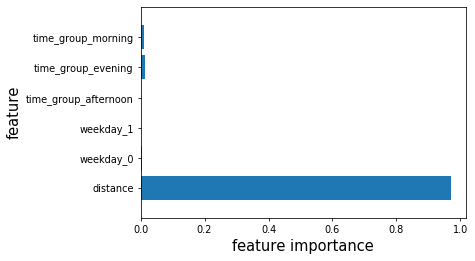

1.0

In [ ]:
n_feature = X_train.shape[1] #주어진 변수들의 갯수를 구함
index = np.arange(n_feature)

plt.barh(index, model.feature_importances_, align='center') 
plt.yticks(index, features)
plt.ylim(-1, n_feature)
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()
np.sum(model.feature_importances_)

In [ ]:
result = model.predict(X_test) # 시험 데이터 예측

test['next_arrive_time'] = result # next_arrive_time 예측 결과로 추가
test[['id', 'next_arrive_time']].to_csv('/content/drive/MyDrive/codestates/Section2/project/bus_station/result6.csv',index=False, float_format='%.2f') # csv로 변환

5.시각화

In [ ]:
# dpi(dots per inch) 수치를 조정해 이미지 화질을 조정 할 수 있습니다
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 70

In [ ]:
feature = 'distance'

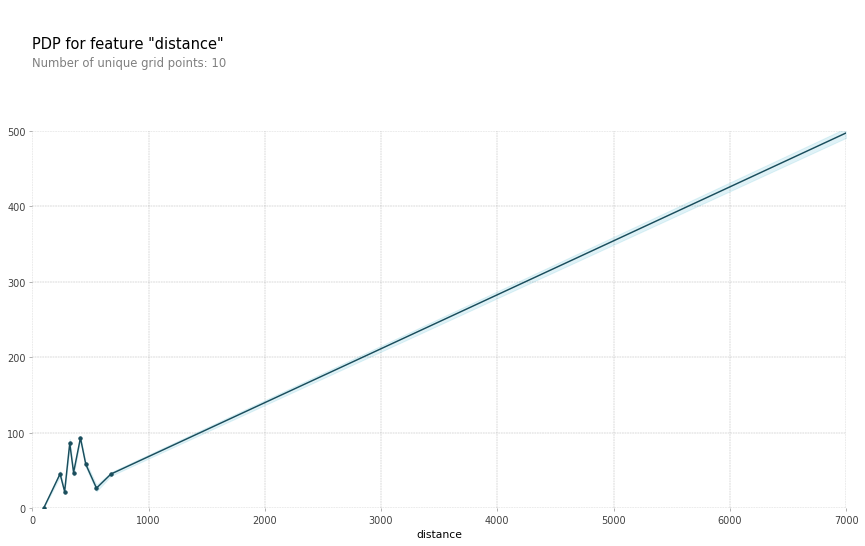

In [ ]:
pdp_plot(isolated, feature_name=feature)
plt.xlim((0,7000));
plt.ylim((0,500));

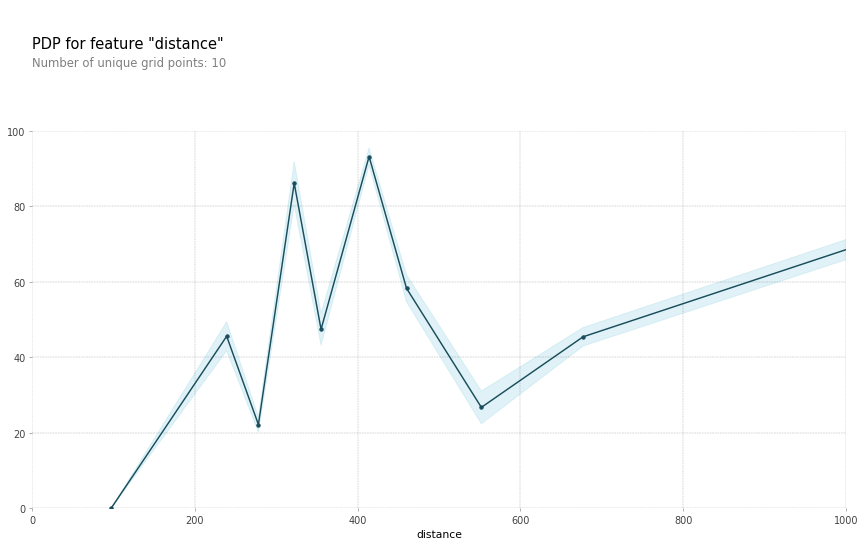

In [ ]:
pdp_plot(isolated, feature_name=feature)
plt.xlim((0,1000));
plt.ylim((0,100));

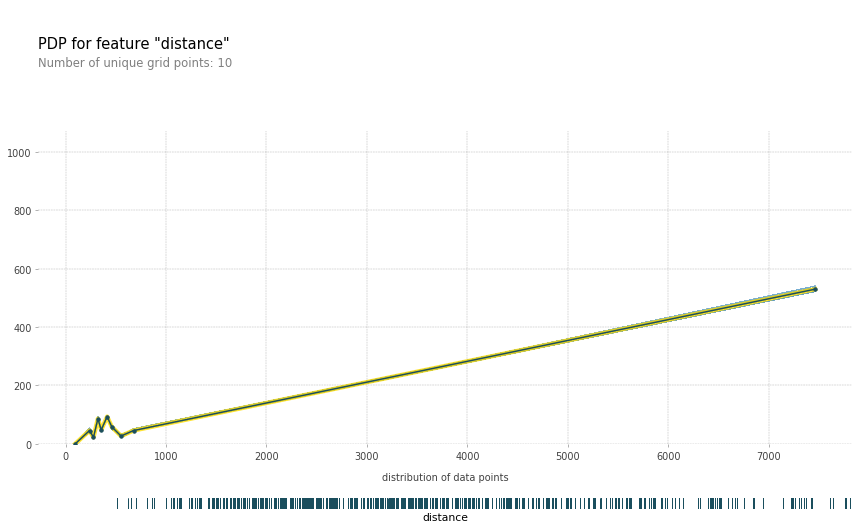

In [ ]:
pdp_plot(isolated
         , feature_name=feature
         , plot_lines=True # ICE plots
         , frac_to_plot=0.01 # or 10 (# 10000 val set * 0.001)
         , plot_pts_dist=True) 

plt.xlim((0,1000));
plt.ylim((0,100));

In [ ]:
row = X_test.iloc[[4]]  # 중첩 brackets을 사용하면 결과물이 DataFrame입니다
row

,distance,weekday_0,weekday_1,time_group_afternoon,time_group_evening,time_group_morning
4,550.0,1,0,0,0,1


In [ ]:
# 모델이 이렇게 예측한 이유를 알기 위하여
# SHAP Force Plot을 그려보겠습니다.

shap.initjs()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row
)

In [ ]:
# 100개 테스트 샘플에 대해서 각 특성들의 영향을 봅니다. 샘플 수를 너무 크게 잢으면 계산이 오래걸리니 주의하세요.
shap.initjs()
shap_values = explainer.shap_values(X_test.iloc[:300])
shap.force_plot(explainer.expected_value, shap_values, X_test.iloc[:300])

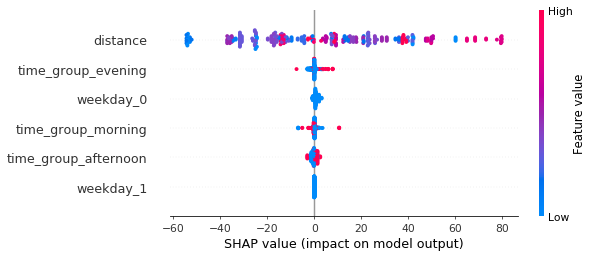

In [ ]:
shap.initjs()
shap_values = explainer.shap_values(X_test.iloc[:300])
shap.summary_plot(shap_values, X_test.iloc[:300])

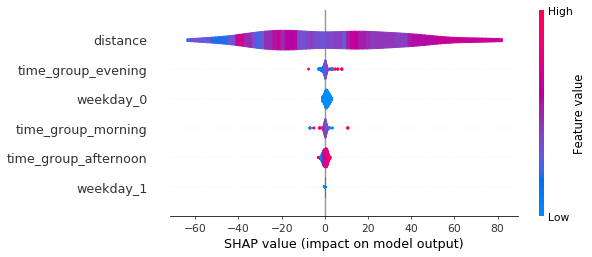

In [ ]:
shap.initjs()

shap.summary_plot(shap_values, X_test.iloc[:300], plot_type="violin")